# Self-Driving Car Engineer Nanodegree

## Deep Learning

---
## Project: Build a Traffic Sign Recognition Classifier

This notebook shows and documents the implementation of a Traffic Sign Recognition Classifier loosely based on the LeNet convolutional neural network architecture.

The input images come from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). An analysis of the dataset is shown and an augmentation strategy for it proposed and implemented.

The classifier is trained using an AWS GPU instance, and reaches an accuracy of more than 93%. 

---
## General Libraries Import

In [2]:
# General math
import numpy as np
import random

# Data import/management/handling
import pickle
import csv
from collections import Counter
from sklearn.utils import shuffle

# Plotting and image manipulation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# NOTE: Import cv2 only if you need to generate the augmented dataset
import cv2

# Tensorflow
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Time is used to measure performances in training
import time

---
## Loading and Analyzing the Data

The original pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.


In [2]:
# Load original pickled data
training_file = '../traffic-signs-data/train.p'
validation_file='../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Basic Summary of the Data Set

We can assess/verify:

* The size of the Training/Validation/Test dataset
* The shape (size) of the images
* The number of idipendent classes (type of traffic signes) to identify

In [3]:
# Number of training examples: the length of X_train
n_train = len(X_train)

# Number of validation examples: the length of X_valid
n_validation = len(X_valid)

# Number of validation examples: the length of X_test
n_test = len(X_test)

# Shape of the image: any element of X_train/X_valid/X_test can be used to deduce it
image_shape = X_train[0].shape

# To identify the number of classes in the dataset we can extract the number of unique elements in the label vectors
u_classes, indices_uc = np.unique(y_train, return_index=True)
n_classes = len(u_classes)

# Finally, it is also a good idea to verify that the dataset is consistent
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Printout results
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization and Analysis

The next two cells of code are going to: 
* Provide a visualization of the first instance of every class in the training datatset
* Calculate the actual number of occurrences for every class in the training dataset and then visualize them as an histogram 

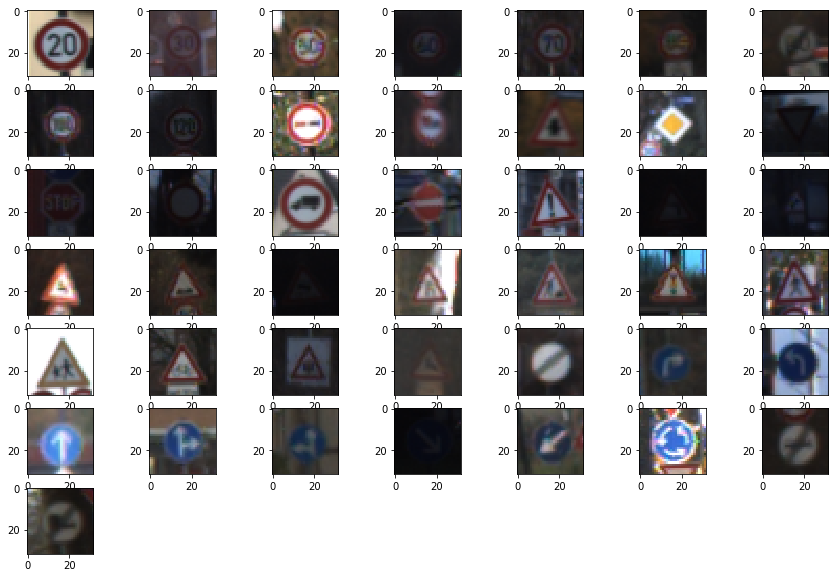

In [4]:
# Plot an instance of every image
%matplotlib inline

# Set the output image for 7 columns, and derive the number of rows
n_columns = 7
n_rows = int(np.ceil(len(u_classes)/n_columns))

# Define a reference size for the output figure
plt.figure(figsize=(15,10))

# Iterate over the vector of indices obtained in the previous code cell 
i=0
for index in (indices_uc):
    image = X_train[index]
    i=i+1
    plt.subplot(n_rows,n_columns,i)    
    plt.imshow(image)
    
    
# SAVE: Uncomment the following to save output in a file 
# plt.savefig("./figures/nominal_dataset.jpg")

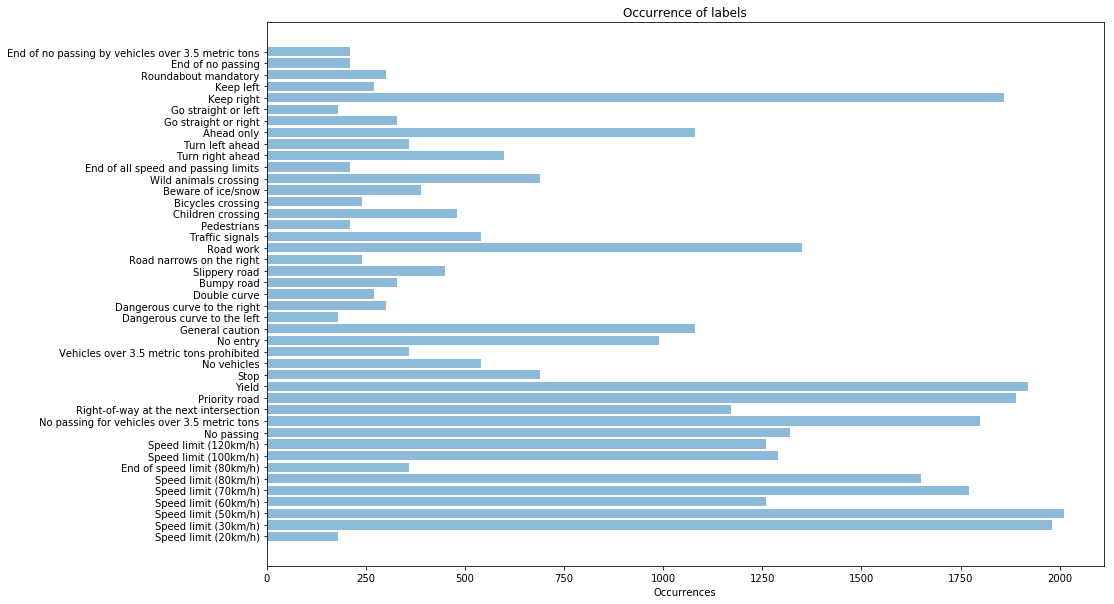

In [5]:
# Generate a histogram of the training data

# First, identify the number of occurrence for each label: we can use a counter on the y_train vector for this
#
z = np.array(Counter(y_train).most_common())
lbls=z[:,0] # Array of lables
occs=z[:,1] # Occurrence of every label, ordered from the most common

# To make the histogram more meaningful, we're going to plot the occurrence against the actual text describing
# the sign, rather than the alphanumeric label. To couple the two, we need to parse the 'signames.csv' file
#
lbls_text=[] # Vector that will contain the parsed output of the .csv
lbls_sh=[]   # Vector that will contain the "shuffled" labels, ordered from the most common 

with open('signnames.csv', newline='') as csvfile:
    filereader = csv.reader(csvfile, delimiter=',')
    for row in filereader:
        if row[0].isnumeric():
            lbls_text.append(row[1])

for i in np.nditer(lbls):
    lbls_sh.append(lbls_text[i])

# Finally we can plot the histogram
#
plt.figure(figsize=(15,10))
plt.barh(lbls,occs,align='center', alpha=0.5)
plt.yticks(lbls, lbls_sh)
plt.xlabel('Occurrences')
plt.title('Occurrence of labels')

# SAVE: Uncomment the following to save output in a file 
# plt.savefig("./figures/nominal_dataset_histogram.jpg")

# Show
plt.show()

---
## Augmentation of the Original Dataset

The original dataset seems to be heavily unbalanced, with some signs significantly more common than others. Another characteristics that seems to describe the original data is the degree of "darkness" of some images.

In order to cope with bothe the issues we are going to use an _augmented_ the dataset containing additional images. Those images would be:

* Generated by the original ones, applying a random rotation and/or a random change in lighthing 
* In a number such that every class will have a number of instances exactly equal to the one that currently is the most represented ('Speed Limit (50 km/h)', with 2010 occurrences)

> **Note**: The set of code cells performing the augmentation is actually _very_ time consuming to run. For this reason, thay are included as an appendix at the bottom of this notebook, but in the following the extended data is directly loaded from a dictionary with only the `'augmented_features'` and `'augmented_labels'` pairs.


In [6]:
# Loading augmented training dataset
extended_training_file = '../traffic-signs-data/augmented_train.p'

with open(extended_training_file, mode='rb') as f:
    aug_train = pickle.load(f)
    
X_train_aug,y_train_aug = aug_train['augmented_pictures'], aug_train['augmented_labels']


# Number of training examples: the length of X_train_aug
n_train_aug = len(X_train_aug)

# Consistency check
assert(len(X_train_aug) == len(y_train_aug))

# Printout results
print("Number of augmented training examples =", n_train_aug)

Number of augmented training examples = 86388


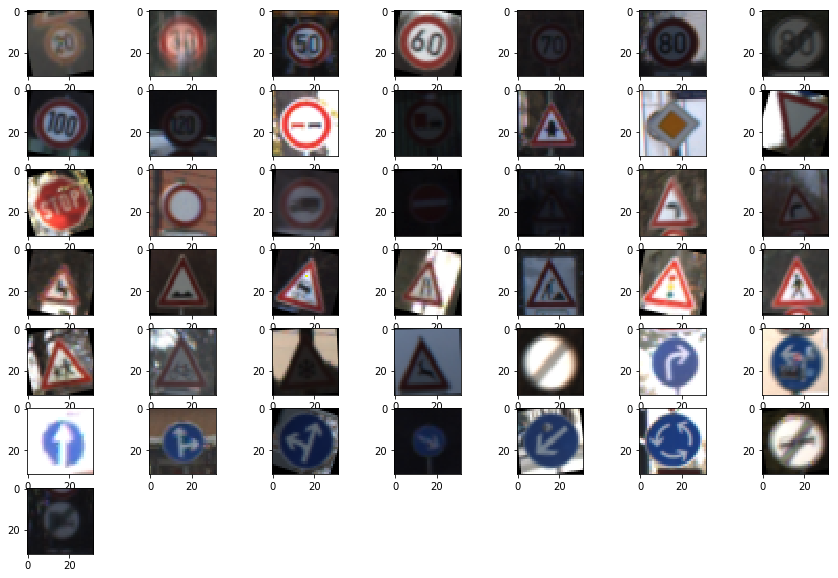

In [7]:
# Plot an instance of every image in the augmented dataset

# Note: in case needed, the following values can change - otherwise thay can be left as they were for plotting the 
# original dataset
# n_columns = 7
# n_rows = int(np.ceil(len(u_classes)/n_columns))

# The augmentation routine appended the new images at the bottom of the original vectors, so we need a shuffle or 
# we'd see the same picture shown before
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

# Given the shuffle, we'll have to recalculate the indices for the first occurrence of every class
u_classes, indices_uc = np.unique(y_train_aug, return_index=True)

# Define a reference size for the output figure
plt.figure(figsize=(15,10))

# Iterate over the vector of indices obtained here
i=0
for index in (indices_uc):
    image = X_train_aug[index]
    i=i+1
    plt.subplot(n_rows,n_columns,i)    
    plt.imshow(image)
    

# SAVE: Uncomment the following to save output in a file 
# plt.savefig("./figures/augmented_dataset.jpg")

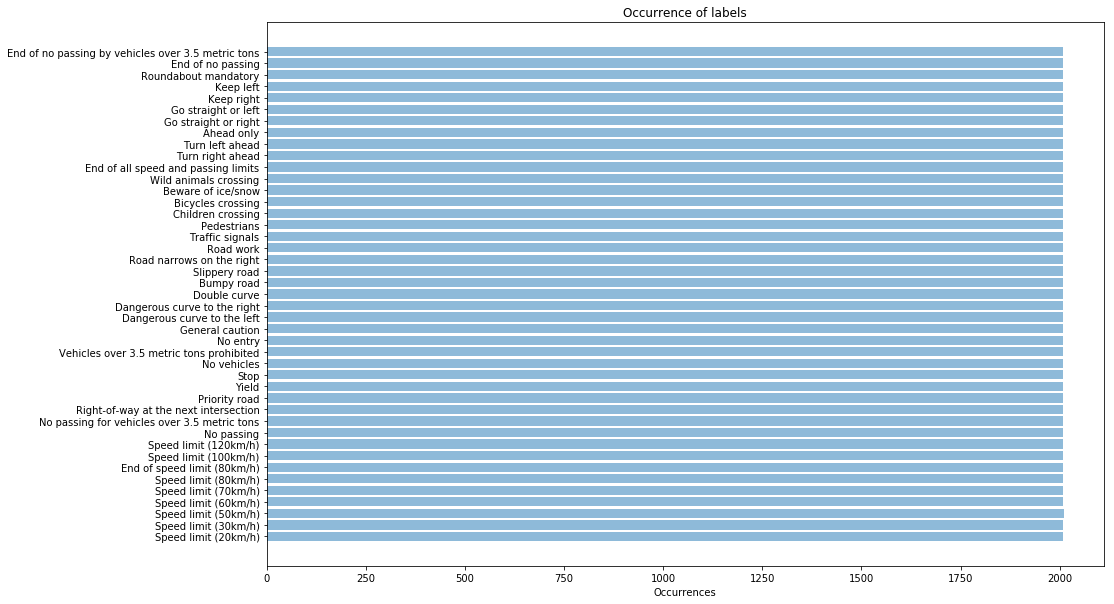

In [8]:
# Generate a histogram of the training data
# The code in this cell is mostly the same that was used for the previous histogram, with the only 
# change in the vector we're using

# First, identify the number of occurrence for each label: we can use a counter on the y_train_aug vector for this
#
z = np.array(Counter(y_train_aug).most_common())
lbls=z[:,0] # Array of lables
occs=z[:,1] # Occurrence of every label, ordered from the most common

# To make the histogram more meaningful, we're going to plot the occurrence against the actual text describing
# the sign, rather than the alphanumeric label. To couple the two, we already parsed the 'signames.csv' file
#
# lbls_text is a vector containing the parsed output of the .csv, and was obtained for the previous histogram
#
lbls_sh=[]   # Vector that will contain the "shuffled" labels, ordered from the most common 

for i in np.nditer(lbls):
    lbls_sh.append(lbls_text[i])

# Finally we can plot the histogram
#
plt.figure(figsize=(15,10))
plt.barh(lbls,occs,align='center', alpha=0.5)
plt.yticks(lbls, lbls_sh)
plt.xlabel('Occurrences')
plt.title('Occurrence of labels')

# SAVE: Uncomment the following to save output in a file 
# plt.savefig("./figures/augmented_dataset_histogram.jpg")

# Show
plt.show()

---
## Definition of the Neural Network Architecture

As detailed in the readme file serving as a writeup for this project, the starting point for this Neural Network Architecture was LeNet, with some subsequent modifications

### Pre-Processing of the images

The actual pre-processing required on the images is fairly minimal, with simple normalization to fall in the range \[-128,128\].

In [9]:
# Normalizing input data

X_train_aug = (X_train_aug-128.0)/128
X_valid = (X_valid-128.0)/128
X_test = (X_test-128.0)/128

### Model Architecture

In [10]:
# Definiton of Num. of Epochs/Batch size 

EPOCHS = 20
BATCH_SIZE = 128

In [11]:
def MyNet(x):    
    
    mu = 0
    sigma = 0.1

    #----------------------------------------------------------------------------------------------------------------
    # In the following the dimension of the Output of the convolutional layers will be calculated using the equations
    # - for VALID PADDING:
    #
    # out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    # out_width = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    #----------------------------------------------------------------------------------------------------------------
    
    # Layer 1: Convolutional. 
    # Input = 32x32x3. 
    # Filter size = 5x5, VALID padding, Strides = 1
    # Output = 28x28x6
    #
    Weights_c1 = tf.Variable(tf.random_normal([5, 5, 3, 6], mean = mu, stddev = sigma))
    Bias_c1 = tf.Variable(tf.random_normal([6], mean = mu, stddev = sigma))
    c1 = tf.nn.conv2d(x, Weights_c1, strides=[1, 1, 1, 1], padding='VALID')
    c1 = tf.nn.bias_add(c1, Bias_c1)
    
    # Layer 1: Activation.
    c1 = tf.nn.relu(c1,name='Layer1_0')
    
    
    # Layer 2: Convolutional. 
    # Input = 28x28x6.
    # Filter size = 5x5, VALID padding, Strides = 1
    # Output = 24x24x12
    #
    Weights_c2 = tf.Variable(tf.random_normal([5, 5, 6, 12], mean = mu, stddev = sigma))
    Bias_c2 = tf.Variable(tf.random_normal([12], mean = mu, stddev = sigma))
    c2 = tf.nn.conv2d(c1, Weights_c2, strides=[1, 1, 1, 1], padding='VALID')
    c2 = tf.nn.bias_add(c2, Bias_c2)
       
    # Layer 2: Activation.
    c2 = tf.nn.relu(c2,name='Layer2_0')
    
    # Layer 2: Droput 
    c2 = tf.nn.dropout(c2,0.50)
    
    
    # Layer 3: Convolutional. 
    # Input = 24x24x12
    # Filter size = 5x5, VALID padding, Strides = 1
    # Output = 20x20x20
    #
    Weights_c3 = tf.Variable(tf.random_normal([5, 5, 12, 20], mean = mu, stddev = sigma))
    Bias_c3 = tf.Variable(tf.random_normal([20], mean = mu, stddev = sigma))
    c3 = tf.nn.conv2d(c2, Weights_c3, strides=[1, 1, 1, 1], padding='VALID')
    c3 = tf.nn.bias_add(c3, Bias_c3)
    
    # Layer 3: Activation.
    c3 = tf.nn.relu(c3,name='Layer3_0')
    
    
    # Layer 4: Convolutional. 
    # Input = 20x20x20
    # Filter size = 5x5, VALID padding, Strides = 1
    # Output = 16x16x30
    #
    Weights_c4 = tf.Variable(tf.random_normal([5, 5, 20, 30], mean = mu, stddev = sigma))
    Bias_c4 = tf.Variable(tf.random_normal([30], mean = mu, stddev = sigma))
    c4 = tf.nn.conv2d(c3, Weights_c4, strides=[1, 1, 1, 1], padding='VALID')
    c4 = tf.nn.bias_add(c4, Bias_c4)
    
    # Layer 4: Activation.
    c4 = tf.nn.relu(c4,name='Layer4_0')
    
    # Layer 4: Dropout.
    c4 = tf.nn.dropout(c4,0.50)
    
    
    # Layer 5: Convolutional. 
    # Input = 16x16x30
    # Filter size = 5x5, VALID padding, Strides = 1
    # Output = 12x12x45
    #
    Weights_c5 = tf.Variable(tf.random_normal([5, 5, 30, 45], mean = mu, stddev = sigma))
    Bias_c5 = tf.Variable(tf.random_normal([45], mean = mu, stddev = sigma))
    c5 = tf.nn.conv2d(c4, Weights_c5, strides=[1, 1, 1, 1], padding='VALID')
    c5 = tf.nn.bias_add(c5, Bias_c5)
    
    # Layer 5: Activation.
    c5 = tf.nn.relu(c5,name='Layer5_0')
   
    
    # Layer 6: Convolutional. 
    # Input = 12x12x45
    # Filter size = 5x5, VALID padding, Strides = 1
    # Output = 8x8x70
    #
    Weights_c6 = tf.Variable(tf.random_normal([5, 5, 45, 70], mean = mu, stddev = sigma))
    Bias_c6 = tf.Variable(tf.random_normal([70], mean = mu, stddev = sigma))
    c6 = tf.nn.conv2d(c5, Weights_c6, strides=[1, 1, 1, 1], padding='VALID')
    c6 = tf.nn.bias_add(c6, Bias_c6)
    
    # Layer 6: Activation.
    c6 = tf.nn.relu(c6,name='Layer6_0')
    
    # Layer 6: Dropout.
    c6 = tf.nn.dropout(c6,0.50)
    
    # Layer 6: Flattening.
    c6 = flatten(c6)
    
    #----------------------------------------------------------------------------------------------------------------
    
    # Layer 7: Fully Connected. Input = 8x8x70 = 4480. Output = 400.
    #
    Weights_c7 = tf.Variable(tf.random_normal([4480, 400], mean = mu, stddev = sigma))
    Bias_c7 = tf.Variable(tf.random_normal([400], mean = mu, stddev = sigma))
    c7 = tf.matmul(c6, Weights_c7) + Bias_c7
    
    # Layer 7: Activation.
    c7 = tf.nn.relu(c7,name='Layer7')

    # Layer 8: Fully Connected. Input = 400. Output = 100.
    #
    Weights_c8 = tf.Variable(tf.random_normal([400, 100], mean = mu, stddev = sigma))
    Bias_c8 = tf.Variable(tf.random_normal([100], mean = mu, stddev = sigma))
    c8 = tf.matmul(c7, Weights_c8) + Bias_c8
    
    # Layer 8: Activation.
    c8 = tf.nn.relu(c8,name='Layer8')
    
    # Layer 8: Droput.
    c8 = tf.nn.dropout(c8,0.50)

    # Layer 9: Classifier, fully Connected. Input = 100. Output = 43.
    Weights_c9 = tf.Variable(tf.random_normal([100, 43], mean = mu, stddev = sigma))
    Bias_c9 = tf.Variable(tf.random_normal([43], mean = mu, stddev = sigma))
    logits = tf.matmul(c8, Weights_c9) + Bias_c9
 
    return logits

### Train, Test and Validate the Model

The following are standard reference cells, with minimal modifications.

In [12]:
# Define TensorFlow placeholders for the training

x = tf.placeholder(tf.float32, (None, 32, 32,3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [13]:
# Define optmizations routines/parameter

rate = 0.001 # Learning Rate: will be kept constant, using the Adam optimization algorythm

logits = MyNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [14]:
# Define prediction/operation routines and evaluation functions

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
# Define a saver for the model

saver = tf.train.Saver()

In [16]:
# Train the model, measuring the time needed 

t = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_aug)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './mynet')
    print("Model saved")

elapsed = time.time() - t
print("Elapsed time (in seconds) = {:.3f}".format(elapsed))

Training...

EPOCH 1 ...
Validation Accuracy = 0.032

EPOCH 2 ...
Validation Accuracy = 0.171

EPOCH 3 ...
Validation Accuracy = 0.669

EPOCH 4 ...
Validation Accuracy = 0.800

EPOCH 5 ...
Validation Accuracy = 0.888

EPOCH 6 ...
Validation Accuracy = 0.884

EPOCH 7 ...
Validation Accuracy = 0.928

EPOCH 8 ...
Validation Accuracy = 0.940

EPOCH 9 ...
Validation Accuracy = 0.944

EPOCH 10 ...
Validation Accuracy = 0.949

EPOCH 11 ...
Validation Accuracy = 0.938

EPOCH 12 ...
Validation Accuracy = 0.948

EPOCH 13 ...
Validation Accuracy = 0.957

EPOCH 14 ...
Validation Accuracy = 0.962

EPOCH 15 ...
Validation Accuracy = 0.959

EPOCH 16 ...
Validation Accuracy = 0.968

EPOCH 17 ...
Validation Accuracy = 0.961

EPOCH 18 ...
Validation Accuracy = 0.966

EPOCH 19 ...
Validation Accuracy = 0.959

EPOCH 20 ...
Validation Accuracy = 0.963

Model saved
Elapsed time (in seconds) = 691.692


In [17]:
# Evaluate the model against the test data

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.939


---

## Test the Model on New Images

6 images of traffic signs have been downloaded from the internet and will be scanned using the model just trained. 

### Load and Output the Images

The images have already been pre-processed and saved in a \[32x32x3\] format. They will be scanned from 6 independent .jpg files, loaded in an array of the appropriate shape, and then shown.
The labels defining them were identified from the `signnames.csv` file, and will be hard-coded in a vector.

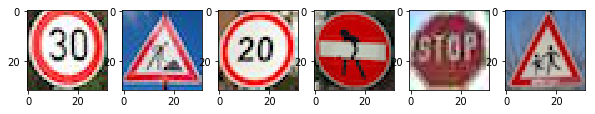

In [18]:
# Define a reference size for the output image
plt.figure(figsize=(10,5))

# Iterate over images 
X_test_web=np.zeros((6,image_shape[0],image_shape[1],3))

for i in range(1, 7):
    in_image = mpimg.imread("traffic_sigs_test-examples/Signal_{}.jpg".format(i))
    X_test_web[i-1] = in_image
    
    plt.subplot(1,6,i)
    plt.imshow(in_image)


#Hard-coding labels
y_test_web=np.zeros(6, dtype=int)

y_test_web[0]=1     # Speed limit (30 km/h)
y_test_web[1]=25    # Road work
y_test_web[2]=0     # Speed limit (20 km/h)
y_test_web[3]=17    # No entry
y_test_web[4]=14    # Stop
y_test_web[5]=28    # Children crossing

### Predict the Sign Type for Each Image, and Analyze Performances

In [19]:
# Pre-process, normalizing image data
X_test_web = (X_test_web-128.0)/128

In [20]:
# Analyze the images
ohe = tf.one_hot(y_test_web, 43)
sm = tf.nn.softmax(logits)
top5 = tf.nn.top_k(sm, k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Top 5 probablities
    tp5 = sess.run(top5,feed_dict={x: X_test_web, y: y_test_web})
    print("Top 5 Probabilities = ", tp5)


# Build the vector of classifications and compare against reference    
y_web_ver=np.zeros(6, dtype=int)
y_web_ver[0]= tp5[1][0][0]
y_web_ver[1]= tp5[1][1][0]
y_web_ver[2]= tp5[1][2][0]
y_web_ver[3]= tp5[1][3][0]
y_web_ver[4]= tp5[1][4][0]
y_web_ver[5]= tp5[1][5][0]

flags = (y_web_ver == y_test_web)

print()
print("True/False flag vectors = ",flags)

# Calculate accuracy
web_acc = np.sum(flags)/6

print()
print("Test Accuracy = {:.3f}".format(web_acc))

Top 5 Probabilities =  TopKV2(values=array([[  6.59084678e-01,   2.82660395e-01,   2.74192747e-02,
          9.30636656e-03,   6.94103912e-03],
       [  9.99999285e-01,   6.29848216e-07,   1.37814752e-07,
          1.95714800e-09,   7.74168452e-10],
       [  7.19003022e-01,   1.86416760e-01,   1.95763092e-02,
          1.71966720e-02,   1.52465208e-02],
       [  9.99107182e-01,   6.85757026e-04,   7.33706402e-05,
          7.04669874e-05,   4.47891471e-05],
       [  2.81708330e-01,   2.15089008e-01,   1.53611824e-01,
          9.17678550e-02,   3.21655497e-02],
       [  1.00000000e+00,   6.11069251e-10,   2.28030456e-10,
          6.81587495e-11,   3.73120068e-12]], dtype=float32), indices=array([[ 1,  0, 34,  8, 17],
       [25, 35, 20,  5, 37],
       [18, 26, 27, 20, 19],
       [14, 17, 34, 26,  9],
       [14, 29, 12, 25, 20],
       [28, 29, 35, 12, 20]], dtype=int32))

True/False flag vectors =  [ True  True False False  True  True]

Test Accuracy = 0.667


---
## Appendix 1 - Data Set Augmentation Code

As explained, the data set was augmented by introducing new images, each one generated starting by a random existing one and then:

* Applying a rando rotation in the range \[-20,20\] degrees
* A random increment in lighting up to the 80%

A check is performed before the lighting change to be sure that it happens only on "dark" images.

The new images and then appended at the bottom of the existing vectors.
New images are generated for underrepresented classes, and the number of samples is defined so to have every class represented as the one that currently has the highest number of items ('Speed Limit (50 km/h)', with 2010 occurrences).

In [ ]:
# Initialize vectors to original dataset
X_train_aug=X_train
y_train_aug=y_train

# Note: the following variables are also defined in the previous code cells. Depending if/when this is executed, 
# they could be commented out
z = np.array(Counter(y_train).most_common())
lbls=z[:,0] # Array of lables
occs=z[:,1] # Occurrence of every label, ordered from the most common

# Iterate on the labels
for i in range(1,len(lbls)-1):
    print('Step :', i)
    
    # How many images are needed. occs[0] is the most common
    delta_img =occs[0]-occs[i]
    print('images needed = ',delta_img)
    
    # Identify the indeces of the images in X_train that are identified by the current label
    searchval = lbls[i]
    ii = np.where(y_train == searchval)[0]
    
    # Iterate on the num. of images needed
    for j in range(1, delta_img):
        
        # pick a random imge associated with the current label
        rand_ind=random.randint(0, len(ii)-1)         
        img = X_train[rand_ind]
        
        # apply a random rotation
        rotation = random.randint(-20, 20)
        M = cv2.getRotationMatrix2D((16,16),rotation,1)
        dst = cv2.warpAffine(img,M,(32,32))
        
        # appy a random lighting increment
        a = np.double(dst)
        avg = np.average(a)
        b=a
        
        # Check on average value
        if (avg<50.0):
            light_inc=(random.random()*0.8)+1
            b = a*light_inc
            
        # Append image and label
        X_train_aug=np.append(X_train_aug,[np.uint8(b)],axis=0)
        y_train_aug=np.append(y_train_aug,searchval)

In [ ]:
# Define a dictionary and dump it in a pickle file

aug_train = {"augmented_pictures":X_train_aug,"augmented_labels":y_train_aug}
pickle.dump( aug_train, open( "augmented_train.p", "wb" ) )

---

## Appendix 2: Visualize the Neural Network's State with Test Images

In this section we will show the output of some of the layers defined in the network, to gain insight on its work. We have named the layers in the architecture, so extracting them will be relatively straightforward.

The layers will be fed with the first of the image loaded from the web.


In [21]:
### Pre-defined function

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

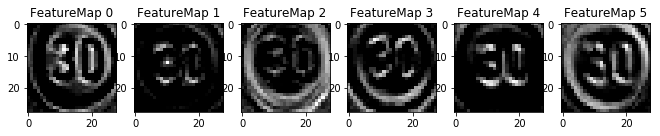

In [22]:
# Extract the first layer
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    lay1=sess.graph.get_tensor_by_name("Layer1_0:0")
    outputFeatureMap(X_test_web[0].reshape(1, 32,32,3),lay1)

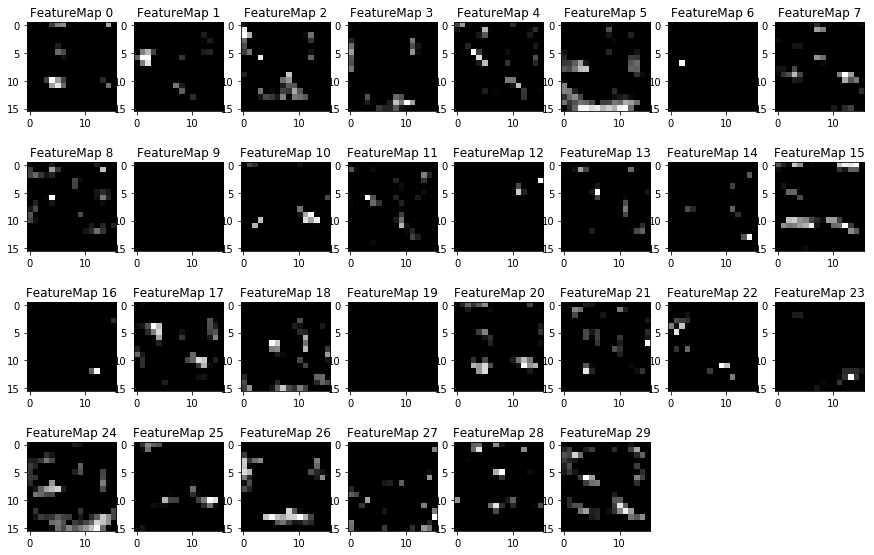

In [23]:
# Extract the fourth layer
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    lay4=sess.graph.get_tensor_by_name("Layer4_0:0")
    outputFeatureMap(X_test_web[0].reshape(1, 32,32,3),lay4)